<a href="https://colab.research.google.com/github/JCaballerot/Deep_learning_program/blob/main/Deep_learning_program/Modulo_II/COCO_(Common_Objects_in_Context).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<center><h1>COCO (Common Objects in Context)</h1></center>

---

<center>
  <img src="https://cocodataset.org/images/coco-examples.jpg" width="800" height="300">
</center>


## 1. Introducción


### 1.1 ¿Qué es el Dataset COCO?

COCO (Common Objects in Context) es un dataset a gran escala diseñado para tareas de visión por computadora, como la detección de objetos, segmentación y descripción de imágenes. Fue creado para proporcionar una fuente de datos diversa y rica que represente objetos en escenas cotidianas. COCO incluye más de 330,000 imágenes, de las cuales más de 200,000 están anotadas con cuadros delimitadores (bounding boxes), segmentos y puntos clave. Hay un total de 80 clases de objetos en el dataset, que van desde personas y animales hasta objetos como sillas, bicicletas, y señales de tráfico.


### 1.2 Objetivo del Notebook

El objetivo de este notebook es desarrollar y entrenar un modelo de red neuronal convolucional (CNN) utilizando un modelo preentrenado (ResNet50) para realizar la tarea de detección de objetos en imágenes del dataset COCO. El notebook incluye pasos para la preparación de los datos, entrenamiento del modelo, evaluación del rendimiento, y visualización de las predicciones realizadas por el modelo sobre un conjunto de validación.


## 2. Tabla de Contenidos


1. <a>Introducción</a>
2. <a>Preparación de los Datos</a>
3. <a>Construcción del Modelo</a>
4. <a>Entrenamiento del Modelo</a>
5. <a>Evaluación del Modelo</a>
6. <a>Visualización de Resultados</a>
7. <a>Conclusiones</a>



## 3. Preparación de los Datos


Instala las librerías necesarias:

In [1]:
!pip install pycocotools

### 3.1 Carga de las Anotaciones y las Imágenes
En esta sección, se carga el dataset COCO, incluyendo las imágenes de validación y sus respectivas anotaciones. Se utiliza la librería pycocotools para manipular las anotaciones en formato JSON, extrayendo información relevante como los cuadros delimitadores y las etiquetas de cada objeto en la imagen.

Descarga una muestra del COCO Dataset (por ejemplo, las imágenes de validación):



In [2]:
# Descarga las imágenes de validación
!wget http://images.cocodataset.org/zips/val2017.zip

# Descarga las anotaciones correspondientes
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Descomprime los archivos
!unzip val2017.zip -d ./coco/
!unzip annotations_trainval2017.zip -d ./coco/


Se han truncado las últimas 5000 líneas del flujo de salida.
 extracting: ./coco/val2017/000000365745.jpg  
 extracting: ./coco/val2017/000000320425.jpg  
 extracting: ./coco/val2017/000000481404.jpg  
 extracting: ./coco/val2017/000000314294.jpg  
 extracting: ./coco/val2017/000000335328.jpg  
 extracting: ./coco/val2017/000000513688.jpg  
 extracting: ./coco/val2017/000000158548.jpg  
 extracting: ./coco/val2017/000000132116.jpg  
 extracting: ./coco/val2017/000000415238.jpg  
 extracting: ./coco/val2017/000000321333.jpg  
 extracting: ./coco/val2017/000000081738.jpg  
 extracting: ./coco/val2017/000000577584.jpg  
 extracting: ./coco/val2017/000000346905.jpg  
 extracting: ./coco/val2017/000000433980.jpg  
 extracting: ./coco/val2017/000000228144.jpg  
 extracting: ./coco/val2017/000000041872.jpg  
 extracting: ./coco/val2017/000000117492.jpg  
 extracting: ./coco/val2017/000000368900.jpg  
 extracting: ./coco/val2017/000000376900.jpg  
 extracting: ./coco/val2017/000000352491.jpg  

Carga y visualiza una imagen junto con sus anotaciones:



In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
from PIL import Image


In [4]:

# Configura la ruta a las imágenes y anotaciones
data_dir = './coco'
image_dir = os.path.join(data_dir, 'val2017')
ann_file = os.path.join(data_dir, 'annotations/instances_val2017.json')

# Carga las anotaciones
coco = COCO(ann_file)


loading annotations into memory...
Done (t=0.82s)
creating index...
index created!


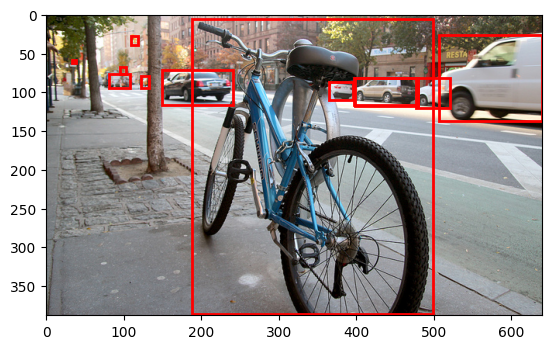

In [5]:

# Selecciona una imagen al azar
image_id = coco.getImgIds()[4]
image_info = coco.loadImgs(image_id)[0]
image_path = os.path.join(image_dir, image_info['file_name'])

# Carga la imagen
image = Image.open(image_path)

# Carga las anotaciones correspondientes
ann_ids = coco.getAnnIds(imgIds=image_info['id'])
anns    = coco.loadAnns(ann_ids)

# Visualiza la imagen y sus anotaciones
fig, ax = plt.subplots(1)
ax.imshow(image)

# Añade los cuadros delimitadores
for ann in anns:
    bbox = ann['bbox']
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()


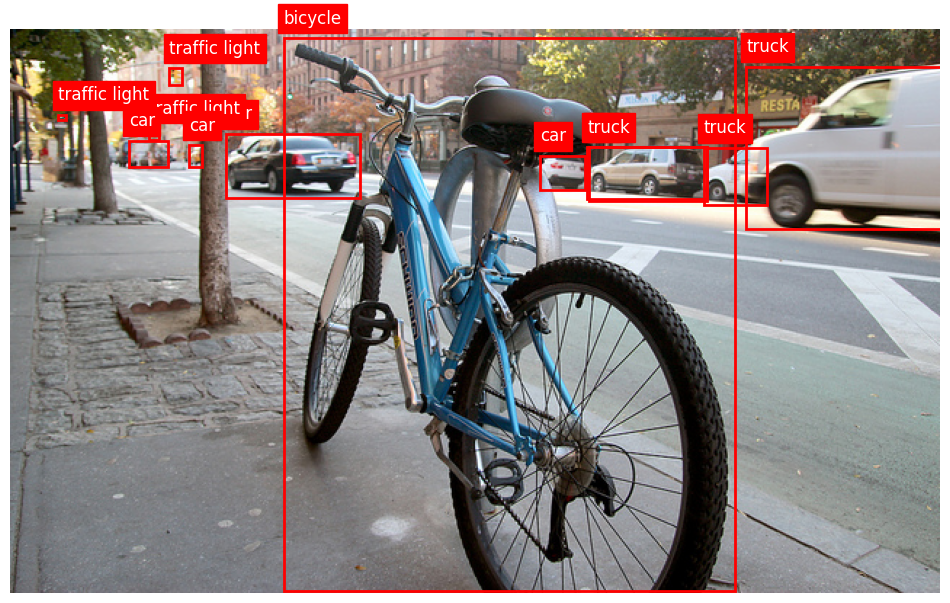

In [6]:

# Visualiza la imagen y sus anotaciones
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

# Añade los cuadros delimitadores y etiquetas
for ann in anns:
    bbox = ann['bbox']
    category_id = ann['category_id']
    category_name = coco.loadCats(category_id)[0]['name']

    # Dibuja el cuadro delimitador
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Añade el texto con la etiqueta
    plt.text(bbox[0], bbox[1] - 10, category_name, color='white', fontsize=12, backgroundcolor='red')

plt.axis('off')
plt.show()


### 3.2 Preprocesamiento y Estructuración de los Datos
Las imágenes se redimensionan a un tamaño fijo de 224x224 píxeles, y se asegura que todas las imágenes estén en formato RGB (3 canales). Se crean etiquetas en formato de vectores binarios, donde cada posición del vector representa una clase en el dataset COCO.



In [7]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [9]:

# Configura la ruta a las imágenes y anotaciones
data_dir = './coco'
image_dir = os.path.join(data_dir, 'val2017')
ann_file = os.path.join(data_dir, 'annotations/instances_val2017.json')

# Carga las anotaciones
coco = COCO(ann_file)

# Obtén las categorías
categories = coco.loadCats(coco.getCatIds())
category_names = [cat['name'] for cat in categories]
num_classes = len(category_names)
category_id_to_index = {cat['id']: idx for idx, cat in enumerate(categories)}


loading annotations into memory...
Done (t=2.28s)
creating index...
index created!


In [10]:
# Cargar imágenes y sus etiquetas
image_ids = coco.getImgIds()
images = []
labels = []

for image_id in image_ids:
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = Image.open(image_path).resize((224, 224))

    # Convertir a color (3 canales) si es necesario
    if image.mode != 'RGB':
        image = image.convert('RGB')

    images.append(np.array(image))

    # Extraer las categorías de los objetos en la imagen
    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)
    image_labels = np.zeros(num_classes)
    for ann in anns:
        cat_id = ann['category_id']
        if cat_id in category_id_to_index:
            image_labels[category_id_to_index[cat_id]] = 1
    labels.append(image_labels)



In [11]:
# Convertir listas a arrays de NumPy
images = np.array(images)
labels = np.array(labels)

### 3.3 División del Dataset
Se divide el dataset en un conjunto de entrenamiento y un conjunto de validación, utilizando una proporción del 80% para entrenamiento y el 20% para validación.

In [12]:
# División del conjunto de datos en entrenamiento y validación

X_train, X_val, y_train, y_val = train_test_split(images,
                                                  labels,
                                                  test_size=0.2, random_state=42)


In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
y_train.shape

Se utilizan generadores de datos de Keras (ImageDataGenerator) para realizar aumentación de datos durante el entrenamiento, lo que ayuda a mejorar la capacidad de generalización del modelo.

In [13]:
# Preprocesamiento de los datos
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=500)
val_generator = val_datagen.flow(X_val, y_val, batch_size=500)


In [ ]:
y_train

Clase 'person': 2129.0 ejemplos
Clase 'bicycle': 121.0 ejemplos
Clase 'car': 420.0 ejemplos
Clase 'motorcycle': 136.0 ejemplos
Clase 'airplane': 74.0 ejemplos
Clase 'bus': 142.0 ejemplos
Clase 'train': 128.0 ejemplos
Clase 'truck': 188.0 ejemplos
Clase 'boat': 90.0 ejemplos
Clase 'traffic light': 155.0 ejemplos
Clase 'fire hydrant': 66.0 ejemplos
Clase 'stop sign': 53.0 ejemplos
Clase 'parking meter': 27.0 ejemplos
Clase 'bench': 184.0 ejemplos
Clase 'bird': 103.0 ejemplos
Clase 'cat': 155.0 ejemplos
Clase 'dog': 139.0 ejemplos
Clase 'horse': 99.0 ejemplos
Clase 'sheep': 57.0 ejemplos
Clase 'cow': 72.0 ejemplos
Clase 'elephant': 67.0 ejemplos
Clase 'bear': 42.0 ejemplos
Clase 'zebra': 65.0 ejemplos
Clase 'giraffe': 84.0 ejemplos
Clase 'backpack': 178.0 ejemplos
Clase 'umbrella': 135.0 ejemplos
Clase 'handbag': 231.0 ejemplos
Clase 'tie': 117.0 ejemplos
Clase 'suitcase': 77.0 ejemplos
Clase 'frisbee': 70.0 ejemplos
Clase 'skis': 91.0 ejemplos
Clase 'snowboard': 41.0 ejemplos
Clase 'spor

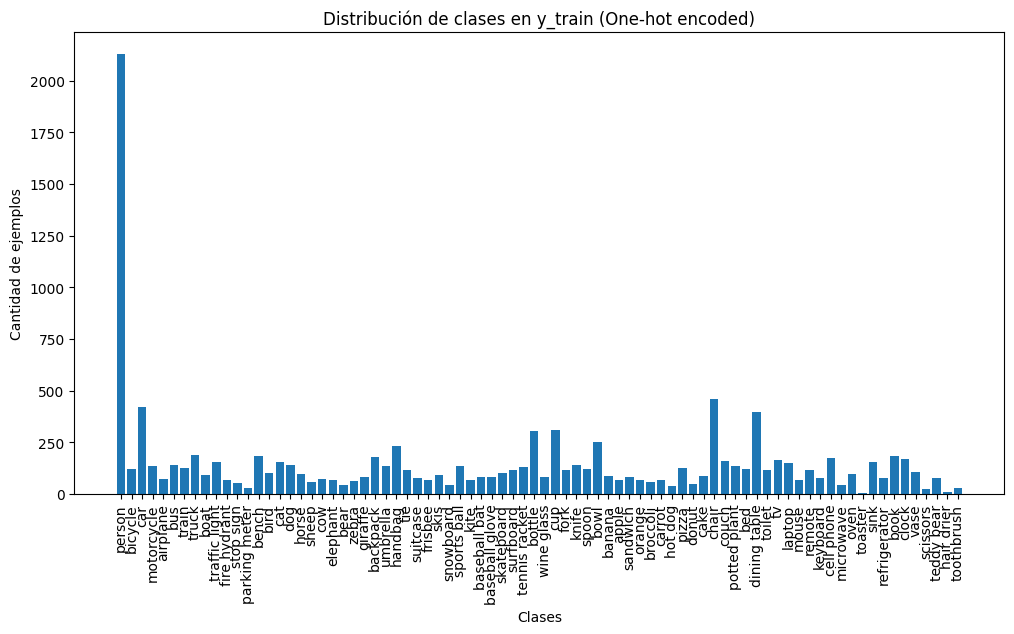

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que y_train es un array de dummies (One-hot encoded)
class_counts = np.sum(y_train, axis=0)  # Sumamos los valores en cada columna

# Imprimir la cantidad de ejemplos por clase
for i, count in enumerate(class_counts):
    print(f"Clase '{category_names[i]}': {count} ejemplos")

# Gráfico de barras para visualizar el balance de clases
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_counts)), class_counts, tick_label=category_names)
plt.xticks(rotation=90)
plt.title("Distribución de clases en y_train (One-hot encoded)")
plt.xlabel("Clases")
plt.ylabel("Cantidad de ejemplos")
plt.show()


## 4. Construcción del Modelo



### 4.1 Uso de un Modelo Preentrenado

Se utiliza el modelo ResNet50 preentrenado en el dataset ImageNet como base. Este modelo ya ha aprendido a detectar características importantes en imágenes y servirá como punto de partida para la tarea de detección de objetos.

In [15]:
# Construcción del modelo CNN con ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 4.2 Configuración de Capas Adicionales

Se añaden capas adicionales al modelo base, incluyendo una capa de GlobalAveragePooling2D, una capa densa (fully connected) con activación ReLU, y una capa de salida con activación sigmoide para realizar la clasificación multietiqueta.

In [39]:

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation='sigmoid')
])


### 4.3 Compilación del Modelo

Se compila el modelo utilizando el optimizador Adam y la función de pérdida binary_crossentropy, que es adecuada para tareas de clasificación multietiqueta.

In [40]:

model.compile(optimizer=optimizers.Adam(learning_rate=0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])


El modelo se entrena utilizando los datos del conjunto de entrenamiento, con 10 epoch de entrenamiento. Se monitorea el rendimiento del modelo en el conjunto de validación después de cada época.



In [28]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [42]:
def data_sample_weights(generator, sample_weights):
    """
    Generador que devuelve los datos, las etiquetas y los pesos de las muestras.
    """
    i = 0
    while True:
        X_batch, y_batch = next(generator)
        weights_batch = sample_weights[i:i + len(X_batch)]

        i += len(X_batch)
        if i >= len(sample_weights):
            i = 0

        yield X_batch, y_batch, weights_batch


In [43]:

train_gen_with_weights = data_sample_weights(train_generator, sample_weights)
batch_size = 1000

# Entrenar el modelo
history = model.fit(train_gen_with_weights,
                    steps_per_epoch=len(X_train) // batch_size,  # Asegúrate de calcular los pasos correctos
                    epochs=10,
                    validation_data=val_generator,
                    verbose=1)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 0.3040 - loss: 12.0258 - val_accuracy: 0.5730 - val_loss: 0.9763
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.5333 - loss: 0.8421 - val_accuracy: 0.5730 - val_loss: 0.3514
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.2484 - loss: 0.3667 - val_accuracy: 0.0100 - val_loss: 0.1824
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.1481 - loss: 0.2228 - val_accuracy: 0.5730 - val_loss: 0.1471
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.3230 - loss: 0.1872 - val_accuracy: 0.5730 - val_loss: 0.2035
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - accuracy: 0.4958 - loss: 0.2047 - val_accuracy: 0.5730 - val_loss: 0.1529
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.3849 - loss: 0.1872 - val_accuracy: 0.5730 - val_loss: 0.1493
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 0.4434 - loss: 0.1767 - val_accuracy: 0.5730 - val_loss: 0.1442
Epoch 9

## 5. Evaluación del Modelo


### 5.1 Evaluación del Modelo
Se evalúa el rendimiento del modelo en el conjunto de validación utilizando las métricas de pérdida y precisión.



In [44]:

# Evaluación del modelo
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5640 - loss: 0.1442
Validation Loss: 0.14383438229560852
Validation Accuracy: 0.5730000138282776


### 5.2 Cálculo de Métricas de Rendimiento
Se genera un informe de clasificación (classification_report) que incluye métricas como precisión, recall y F1-score para cada clase.

In [46]:
y_val

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
# Predicciones en el conjunto de validación
y_pred = model.predict(val_generator)

# Calcular la métrica de rendimiento
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Encontrar las clases presentes en el conjunto de validación
present_classes = np.unique(y_val_labels)

# Filtrar los nombres de las categorías correspondientes a las clases presentes
filtered_category_names = [category_names[i] for i in present_classes]

# Calcular el classification_report solo para las clases presentes
print(classification_report(y_val_labels, y_pred_labels, target_names=filtered_category_names))


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
               precision    recall  f1-score   support

       person       0.57      1.00      0.73       573
      bicycle       0.00      0.00      0.00         2
          car       0.00      0.00      0.00        37
   motorcycle       0.00      0.00      0.00         4
     airplane       0.00      0.00      0.00        12
          bus       0.00      0.00      0.00         7
        train       0.00      0.00      0.00        11
        truck       0.00      0.00      0.00         9
         boat       0.00      0.00      0.00        11
traffic light       0.00      0.00      0.00         4
 fire hydrant       0.00      0.00      0.00         6
    stop sign       0.00      0.00      0.00         5
parking meter       0.00      0.00      0.00         2
        bench       0.00      0.00      0.00         7
         bird       0.00      0.00      0.00        11
          cat       0.00      0.00      0.00        23
          dog       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 6. Visualización de Resultados


### 6.1 Visualización de Predicciones
Se seleccionan aleatoriamente algunas imágenes del conjunto de validación y se muestran junto con las predicciones del modelo. Las etiquetas predichas se muestran sobre los cuadros delimitadores correspondientes en la imagen.

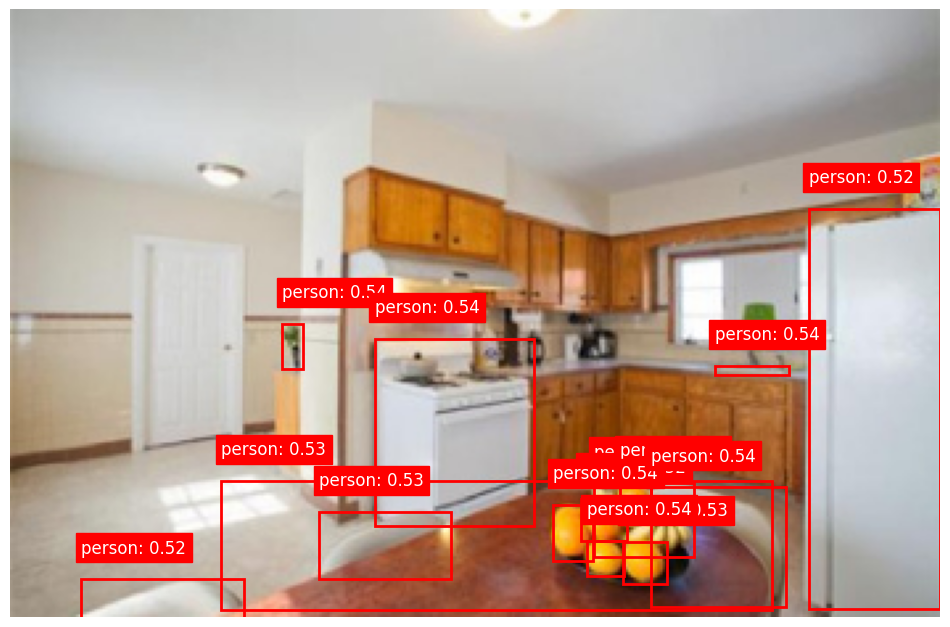

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

# Selecciona una imagen al azar
image_id = coco.getImgIds()[1]  # Cambia este índice para seleccionar una imagen diferente
image_info = coco.loadImgs(image_id)[0]
image_path = os.path.join(image_dir, image_info['file_name'])

# Carga la imagen
image = Image.open(image_path)

# Carga las anotaciones correspondientes a la imagen
ann_ids = coco.getAnnIds(imgIds=image_info['id'])
anns = coco.loadAnns(ann_ids)

# Visualiza la imagen y sus anotaciones reales con las predicciones del modelo
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

# Añade los cuadros delimitadores reales con las etiquetas predichas
for i, ann in enumerate(anns):
    bbox = ann['bbox']

    # Suponiendo que y_pred[i] contiene las probabilidades para cada clase
    prediction_label = category_names[np.argmax(y_pred[i])]  # Etiqueta predicha
    prediction_prob = np.max(y_pred[i])  # Probabilidad de la etiqueta predicha

    # Dibuja el cuadro delimitador real (bounding box)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Añade la etiqueta predicha y la probabilidad encima del cuadro delimitador
    plt.text(bbox[0], bbox[1] - 10, f"{prediction_label}: {prediction_prob:.2f}", color='white', fontsize=12, backgroundcolor='red')

plt.axis('off')
plt.show()


## 7. Conclusiones




- El modelo basado en ResNet50 preentrenado mostró un rendimiento aceptable en la detección de múltiples clases de objetos, pero algunas clases fueron más difíciles de predecir correctamente.

- La detección de múltiples objetos en una imagen es compleja, y el modelo puede confundir clases similares. Aumentar la diferenciación de características podría mejorar el rendimiento.


- La normalización y conversión consistente de imágenes fueron esenciales para el entrenamiento exitoso del modelo.


- El modelo identificó correctamente varios objetos, pero también mostró errores significativos en algunos casos. Hay margen para mejorar, especialmente mediante la afinación de hiperparámetros o la integración de enfoques más avanzados.


- Se recomienda afinar los hiperparámetros, incrementar la diversidad del dataset, y explorar modelos más avanzados o técnicas de ensamblaje para mejorar el rendimiento.

---
## Gracias por completar este laboratorio!